# Imports

In [1]:
import numpy as np
import yfinance as yf
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import IchimokuLibrary
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
import random
import os
from dateutil.relativedelta import relativedelta

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import arch.bootstrap as ab

In [2]:
START = "2015-01-01"
END = "2025-01-01"
TICKER = "btcusd"
TITLE = TICKER + " - " + (datetime.now()).strftime("%Y-%m-%d - %H:%M:%S")

In [3]:
# data = yf.download("^GSPC",start=START, end=END,multi_level_index=False)
# data.to_csv("data2.csv")

In [4]:
data = pd.read_csv("data2.csv", index_col=0, parse_dates=True)

# data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))
#
# data.dropna(inplace=True)

In [5]:
data = data.drop(columns=["High", "Low", "Open", "Volume"])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-02 to 2024-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [7]:
returns = (np.log(data["Close"] / data["Close"].shift(1)).dropna())

# apply_ichi(returns.cumsum()).plot()

# ichi = apply_ichi(returns.cumsum())
# ichi

In [8]:
returns.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2515 entries, 2015-01-05 to 2024-12-31
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
2515 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


# Signals

In [9]:
IchimokuLibrary.l_1(IchimokuLibrary.apply_ichi(data["Close"])).value_counts()

True     1666
False     850
Name: count, dtype: int64

<Axes: >

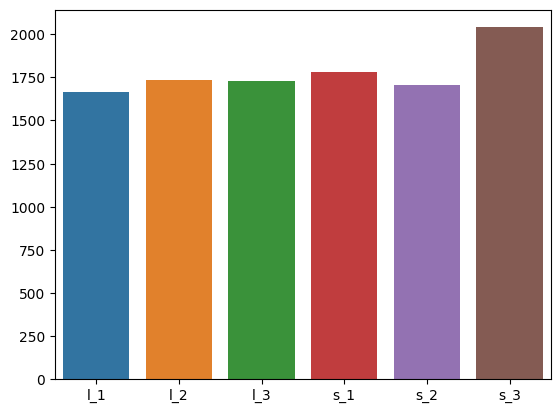

In [10]:
sns.barplot(pd.DataFrame([{signal.__name__: signal(IchimokuLibrary.apply_ichi(data["Close"])).value_counts().iloc[0]} for signal in IchimokuLibrary.BULLISH_SIGNALS + IchimokuLibrary.BEARISH_SIGNALS]))

# Entry

<Axes: >

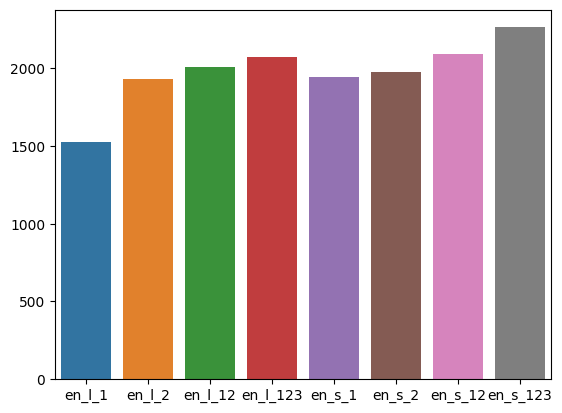

In [11]:
sns.barplot(pd.DataFrame(
    [{x.__name__: x(IchimokuLibrary.apply_ichi(data["Close"])).value_counts().iloc[0]} for x in IchimokuLibrary.ENTRY_SIGNALS_BULL + IchimokuLibrary.ENTRY_SIGNALS_BEAR]))

In [28]:
raise

RuntimeError: No active exception to reraise

# Exit

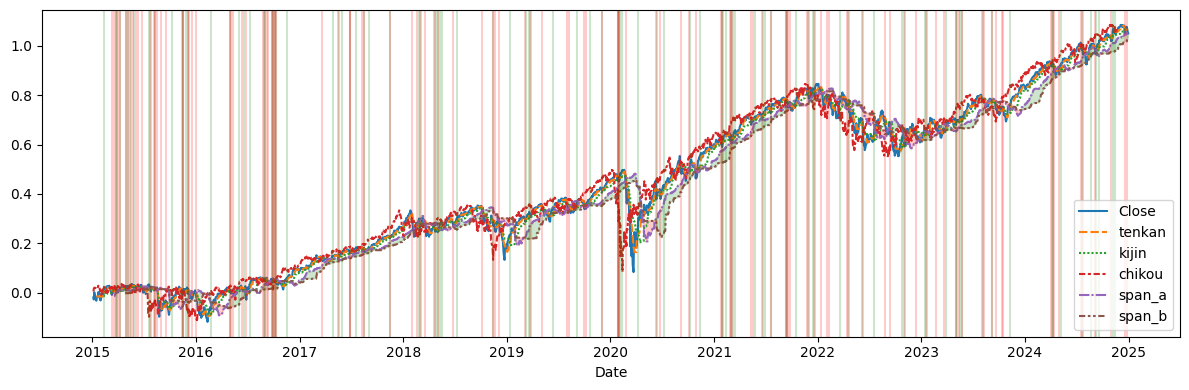

In [12]:
plt.figure(figsize=(12, 4))

ichi_data = IchimokuLibrary.apply_ichi(returns.cumsum())

data_here = ichi_data[:]

ax = sns.lineplot(data=data_here)

signal = IchimokuLibrary.en_l_1

mask = (signal(data_here).dropna() == 1) & (signal(data_here).dropna().shift(1) == 0)

for index, value in mask.items():
    if value:
        ax.axvline(index, alpha=0.2, color="green")

signal = IchimokuLibrary.ex_l_1

mask = (signal(data_here).dropna() == 1) & (signal(data_here).dropna().shift(1) == 0)


for index, value in mask.items():
    if value:
        ax.axvline(index, alpha=0.2, color="red")

ax.fill_between(data_here.index, data_here["span_a"], data_here["span_b"], where=data_here["span_a"] > data_here["span_b"], color="green", alpha=0.2)
ax.fill_between(data_here.index, data_here["span_a"], data_here["span_b"], where=data_here["span_a"] < data_here["span_b"], color="red", alpha=0.2)

plt.tight_layout()

plt.show()

np.float64(0.14783315946836104)

In [13]:
(returns.mean() / returns.std()) * np.sqrt(12)

np.float64(0.12833039679324232)

# Trading Ichimoku

In [14]:
ichi_data = IchimokuLibrary.apply_ichi(returns.cumsum())

trading_data = pd.DataFrame(index=pd.DatetimeIndex(ichi_data.index))

# strategies_l = [[ex_l_1,[en_l_1, en_l_2, en_l_12, en_l_123]], [ex_l_2, [en_l_1, en_l_12, en_l_123]], [ex_l_3, [en_l_2, en_l_12, en_l_123]], [ex_l_4, [en_l_12, en_l_123]], [ex_l_5, [en_l_123]]]
# strategies_s = [[ex_s_1,[en_s_1, en_s_2, en_s_12, en_s_123]], [ex_s_2, [en_s_1, en_s_12, en_s_123]], [ex_s_3, [en_s_2, en_s_12, en_s_123]], [ex_s_4, [en_s_12, en_s_123]], [ex_s_5, [en_s_123]]]

count = 0
for exit, entry_list in IchimokuLibrary.STRATEGIES_L:
    print(exit)
    for entry in entry_list:
        print(f"    {entry}")
        count += 1

print(f"{count=}")

ex_l_1
    en_l_1
    en_l_2
    en_l_12
    en_l_123
ex_l_2
    en_l_1
    en_l_12
    en_l_123
ex_l_3
    en_l_2
    en_l_12
    en_l_123
ex_l_4
    en_l_12
    en_l_123
ex_l_5
    en_l_123
count=13


<Axes: xlabel='Date'>

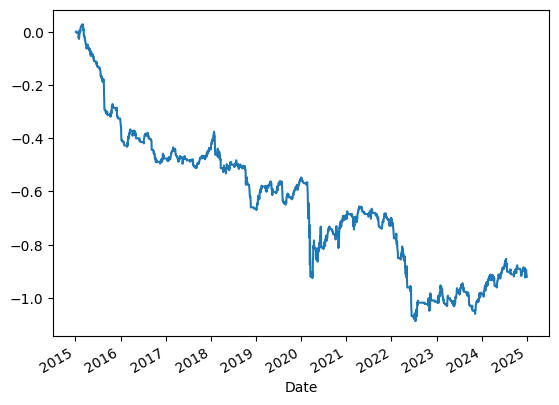

In [15]:
df = IchimokuLibrary.trade(returns, IchimokuLibrary.en_l_1, IchimokuLibrary.ex_l_3, 7, 14, 52)
df.cumsum().plot()


In [16]:
IchimokuLibrary.sharpe_ratio(returns, IchimokuLibrary.en_l_1, IchimokuLibrary.ex_l_1, 9, 26, 52)

mu       -0.071624
sigma     0.106215
Sharpe   -0.674326
dtype: float64

# Bootstrapping

In [17]:
returns = np.log(data["Close"] / data["Close"].shift(1)).dropna()

In [18]:
block_length = ab.optimal_block_length(returns ** 2)["stationary"].iloc[0]

In [19]:
bs = ab.StationaryBootstrap(block_length, returns, seed=44)

In [20]:
results = bs.apply(IchimokuLibrary.sharpe_ratio, 1000, {"entry":IchimokuLibrary.en_l_1, "exit":IchimokuLibrary.ex_l_1, "short": 9, "medium":26,"long": 52})
# run time - 2500 - 2m 58s
# run time - 100 -      7s

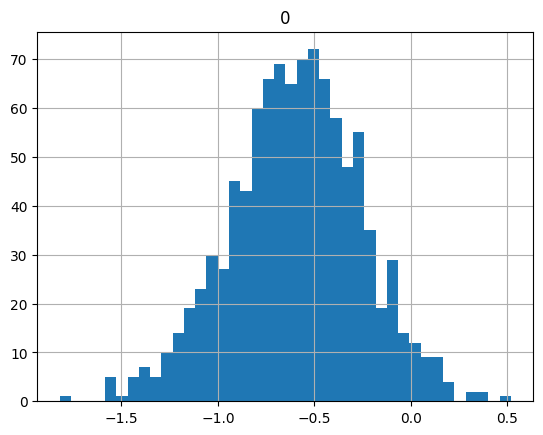

In [21]:
sr = pd.DataFrame(results[:, -1:])

fig = sr.hist(bins=40)

In [22]:
# cov = bs.cov(IchimokuLibrary.sharpe_ratio, 100, extra_kwargs={"entry":en_l_1, "exit":ex_l_1})
# run time 2025/05/18 15:07 - 1000 - 1m 16s
# run time 2025/05/18 15:09 - 1000 - 1m 16s

In [23]:
# ci = bs.conf_int(IchimokuLibrary.sharpe_ratio, 100, method="basic", extra_kwargs={"entry":en_l_1, "exit":ex_l_1})
# run time 100      -      7.4s
# run time 1_000    -  1m 16.6s
# run time 10_000   - 11m 46.7s
    

In [24]:
# ci = pd.DataFrame(ci, index=["Lower", "Upper"], columns=["mu", "sigma", "Sharpe"])
# print(ci)

# SPA

In [25]:
def spa_test(data, trade_parameters, alpha=0.05, verbose=False):
    """
    Benchmark is buy and hold
    
    """
    
    strategy_loss = -IchimokuLibrary.trade(data, trade_parameters["entry"], trade_parameters["exit"], trade_parameters["short"], trade_parameters["medium"], trade_parameters["long"])

    # strategy_loss.plot()

    benchmark_loss = -data


    a = ab.SPA(benchmark_loss, strategy_loss,reps=100)

    a.compute()

    if verbose:
        if a.pvalues["consistent"] < alpha:
            print(f"reject null, The strategy is NOT superior to all benchmarks., p value is {a.pvalues["consistent"]}")
        else:
            print(f"fail to reject null, The strategy is not inferior to any benchmark (supports superiority), p value is {a.pvalues["consistent"]}")
            
    return a.pvalues["consistent"]

In [26]:
trade_parameters = {"entry":"en_l_1", "exit":"ex_l_5", "short":9, "medium": 26, "long":52}

spa_test(returns, trade_parameters)

np.float64(0.52)

In [27]:
IchimokuLibrary.trade(returns, "en_l_1", "ex_l_5", 9, 26, 52).plot()
returns.cumsum().plot()

<Axes: xlabel='Date'>

Error in callback <function flush_figures at 0x00000272861F4220> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
trading_lengths = {
    'short': range(5,15,2), # check
    'medium': range(17,33,2), # check
    'long': range(35,65,2) # check
}

jobs = product(
    trading_lengths['short'], 
    trading_lengths['medium'],
    trading_lengths["long"],
    ((exit, x) for exit, _entry in IchimokuLibrary.STRATEGIES_L for x in _entry)) # 7800

In [ ]:
# list(jobs)[0][0]
# random.seed(44)

# jobs = random.choices(list(universe), k=500)

# jobs = list(jobs)[:10]

# dataframe for results storage
columns = []
for strategy in IchimokuLibrary.STRATEGIES_L:
    ex = strategy[0]
    en_list = strategy[1]
    for en in en_list:
        columns.append((ex, en))

multi_index_columns = pd.MultiIndex.from_tuples(columns)
multi_index_index = pd.MultiIndex.from_tuples(product(trading_lengths['short'], trading_lengths['medium'],trading_lengths["long"], ["Lower", "Upper"]))

trading_spa = pd.DataFrame(columns=multi_index_columns, index=multi_index_index)
# trading_ci.to_excel(file_name)

total = 7800
trades = []
for count, job in enumerate(jobs):
    if count % 250 == 0:
        print(f"{datetime.now().strftime('%H:%M:%S')} - {count}/{total} : {round((count/total)*100,3)}%")

    trades.append(IchimokuLibrary.trade(returns, job[3][1], job[3][0],job[0],job[1],job[2]))

# print(np.array(trades))

18:18:46 - 0/7800 : 0.0%
18:18:47 - 250/7800 : 3.205%
18:18:48 - 500/7800 : 6.41%
18:18:49 - 750/7800 : 9.615%
18:18:50 - 1000/7800 : 12.821%
18:18:51 - 1250/7800 : 16.026%
18:18:52 - 1500/7800 : 19.231%
18:18:53 - 1750/7800 : 22.436%
18:18:54 - 2000/7800 : 25.641%
18:18:55 - 2250/7800 : 28.846%
18:18:56 - 2500/7800 : 32.051%
18:18:57 - 2750/7800 : 35.256%
18:18:58 - 3000/7800 : 38.462%
18:18:59 - 3250/7800 : 41.667%
18:19:00 - 3500/7800 : 44.872%
18:19:01 - 3750/7800 : 48.077%
18:19:02 - 4000/7800 : 51.282%
18:19:03 - 4250/7800 : 54.487%
18:19:04 - 4500/7800 : 57.692%
18:19:05 - 4750/7800 : 60.897%
18:19:06 - 5000/7800 : 64.103%
18:19:07 - 5250/7800 : 67.308%
18:19:08 - 5500/7800 : 70.513%
18:19:09 - 5750/7800 : 73.718%
18:19:10 - 6000/7800 : 76.923%
18:19:11 - 6250/7800 : 80.128%
18:19:12 - 6500/7800 : 83.333%
18:19:13 - 6750/7800 : 86.538%
18:19:14 - 7000/7800 : 89.744%
18:19:15 - 7250/7800 : 92.949%
18:19:16 - 7500/7800 : 96.154%
18:19:17 - 7750/7800 : 99.359%


In [ ]:
# All models
def loss_function(strategy):
    return -strategy

k = np.array(trades).shape[1]

bench_loss = -returns
model_loss = -(np.array(trades).T)
print("doing SPA")
spa_buy_and_hold = ab.SPA(bench_loss,model_loss, reps=1000, seed=44)
spa_buy_and_hold.compute()
# 6m 44s - btc
# 6m 51s - btc
# reps = 100, 4m 15s - btc
# 3m 56s - SP500


doing SPA


KeyboardInterrupt: 

In [ ]:
spa_buy_and_hold.pvalues

lower         0.628
consistent    0.820
upper         0.854
dtype: float64